# Demo Notebook: MLC $C$ Parametrizations

## Import and Set-Up

First, we must import all the relevant libraries.

In [1]:
## General imports ##
# Used for selecting GPU.
import os
# import tensorflow as tf
import torch
import torch.nn as nn
# Used for distributions libraries.
from scipy import stats

## Utility imports ##
from utils.losses import *
from utils.plotting import *
from utils.training import *

# Just this seed isn't enough to ensure results are completely replicable,
# as there is randomness in GPU execution.
np.random.seed(666)

In [2]:
# This cell is to select the GPU.
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Generation

We first set up the data distributions as well as various other aspects of the training.

[Add more about $C$ parametrizations here]

In [3]:
## Mess around with these inputs.

# The trained models will be saved in a folder "set_{num}"
num = 0

# The number of models to train for each parametrization.
reps = 10

# The background and signal distributions.
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)
lr = make_lr(bkgd, sgnl)

# The sample size (N samples are drawn from each distribution for training).
N = 10**6

In [4]:
# Model parameters
learning_rate = 1e-2
nu = 1e-3
eta = 5.
F0 = 1.
optimizer = 'adam' #change to 'adam' to use adam

linear = {'loss_fun':mlc, 'output':'relu', 'optimizer': optimizer, 'learning_rate': learning_rate, 'eta': eta, 'F0': F0, 'nu': nu}
square = {'loss_fun':square_mlc, 'output':'linear', 'optimizer': optimizer, 'learning_rate': learning_rate, 'eta': eta, 'F0': F0, 'nu': nu}
exponl = {'loss_fun':exp_mlc, 'output':'linear', 'optimizer': optimizer, 'learning_rate': learning_rate, 'eta': eta, 'F0': F0, 'nu': nu}



filestr_linear = 'models/demo/set_' + str(num) + '/linear/model_{}.pth'
filestr_square = 'models/demo/set_' + str(num) + '/square/model_{}.pth'
filestr_exponl = 'models/demo/set_' + str(num) + '/exponl/model_{}.pth'

if not os.path.isdir('models/demo/set_' + str(num)):
    os.makedirs('models/demo/set_' + str(num))
    os.makedirs('models/demo/set_' + str(num) + '/linear')
    os.makedirs('models/demo/set_' + str(num) + '/square')
    os.makedirs('models/demo/set_' + str(num) + '/exponl')
    os.makedirs('plots/demo/set_' + str(num))

## Data Generation
data = make_data(bkgd, sgnl, N)# + [N]

In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = data
X_train = X_train.reshape(-1,1).astype(np.float32)
X_test = X_test.reshape(-1,1).astype(np.float32)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

N = len(X_train)+len(X_test)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
train_loader = DataLoader(dataset = trainDataSet(X_train, y_train), batch_size = int(0.1*N))
test_loader = DataLoader(dataset = trainDataSet(X_test, y_test), batch_size = int(0.1*N))

## Training

We train ```reps``` models of each parametrization of the MLC loss.

In [6]:
max_epochs = 100
for i in range(reps):
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs, callbacks=[earlystopping])

    linear_model = create_model(**linear)
    trainer.fit(model=linear_model, train_dataloaders=train_loader)
    # trainer.test(model=model, dataloaders=test_loader)
    torch.save(linear_model.state_dict(), filestr_linear.format(i))
    square_model = create_model(**square)
    trainer.fit(model=square_model, train_dataloaders=train_loader)
    torch.save(square_model.state_dict(), filestr_square.format(i))
    exponl_model = create_model(**exponl)
    trainer.fit(model=exponl_model, train_dataloaders=train_loader)
    torch.save(exponl_model.state_dict(), filestr_exponl.format(i))


# model = create_model(d=1, loss_fun=mlc, output='relu', learning_rate=learning_rate, eta=eta, F0=F0, nu=nu)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# for i in range(reps):
#     print(i, end = ' ')
#     linear_model, linear_trace = train(data, **linear)
#     linear_model.save_weights(filestr_linear.format(i))
#     square_model, square_trace = train(data, **square)
#     square_model.save_weights(filestr_square.format(i))
#     exponl_model, exponl_trace = train(data, **exponl)
#     exponl_model.save_weights(filestr_exponl.format(i))
#     print()

Once all the models are trained, we load them back in and create a likelihood ratio function from each one.

In [9]:
# Get model likelihood ratios.
lrs_linear = [None] * reps
lrs_square = [None] * reps
lrs_exponl = [None] * reps
for i in range(reps):
    model_linear = create_model(**linear)
    model_linear.load_state_dict(torch.load(filestr_linear.format(i)))
    model_linear.eval()
    model_square = create_model(**square)
    model_square.load_state_dict(torch.load(filestr_square.format(i)))
    model_square.eval()
    model_exponl = create_model(**exponl)
    model_exponl.load_state_dict(torch.load(filestr_exponl.format(i)))
    model_exponl.eval()

    lrs_linear[i] = pure_lr(model_linear)
    lrs_square[i] = square_lr(model_square)
    lrs_exponl[i] = exp_lr(model_exponl)

## Visualization

Once we have the model likelihood ratios, we can average together all ```reps``` of our predictions and predict them against the true likelihood ratio.

In [10]:
m = (bkgd.mean() + sgnl.mean()) / 2
s = ((bkgd.var() + sgnl.var()) / 2 + np.var([bkgd.mean(), sgnl.mean()]))**0.5

In [29]:
# Get average predictions and errors. Add on the labels for plotting.
ds = np.linspace(-6, 6, 1000)
xs = (ds - m) / s
xs = torch.from_numpy(xs.reshape(-1,1).astype(np.float32))
with torch.no_grad():
# lr_linear = [model(torch.from_numpy(xs.reshape(-1,1).astype(np.float32)))[:,0].detach().numpy(), 'MLC (linear)']
    lr_linear = [avg_lr(get_preds(lrs_linear, xs)), 'MLC (linear)']
    lr_square = [avg_lr(get_preds(lrs_square, xs)), 'MLC (square)']
    lr_exponl = [avg_lr(get_preds(lrs_exponl, xs)), 'MLC (exponential)']

    lrr_linear = [avg_lrr(lr, get_preds(lrs_linear, xs), ds), 'MLC (linear)']
    lrr_square = [avg_lrr(lr, get_preds(lrs_square, xs), ds), 'MLC (square)']
    lrr_exponl = [avg_lrr(lr, get_preds(lrs_exponl, xs), ds), 'MLC (exponential)']

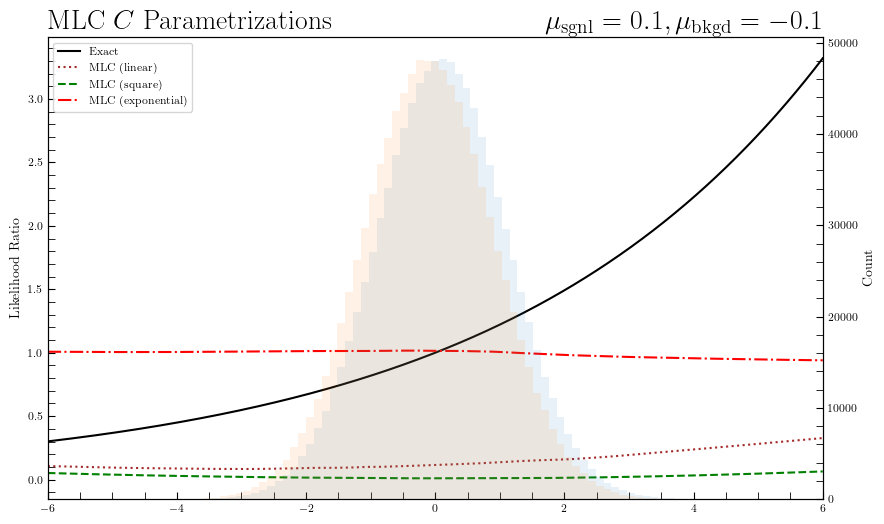

In [35]:
lr_plot([lr_linear, lr_square, lr_exponl], 
        lr,
        bkgd, sgnl,
        xs = ds,
        bins = np.linspace(-6, 6, 100),
        title = r'MLC $C$ Parametrizations',
        filename = 'plots/demo/set_{}/lrs.png'.format(num),
        params = r"$\mu_{\rm{sgnl}}="+str(+0.1)+r", \mu_{\rm{bkgd}}="+str(-0.1)+r"$")

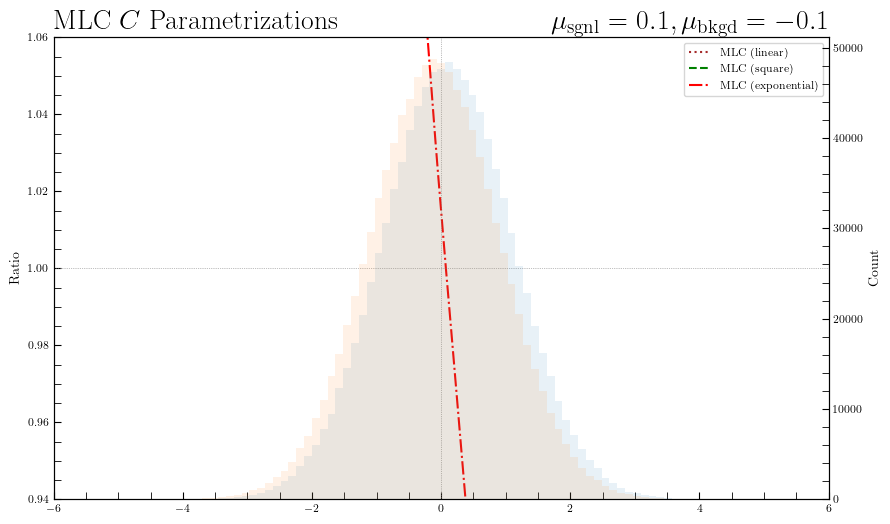

In [36]:
lrr_plot([lrr_linear, lrr_square, lrr_exponl], 
         lr,
         bkgd, sgnl,
         xs = ds,
         bins = np.linspace(-6, 6, 100),
         title = r'MLC $C$ Parametrizations',
         filename = 'plots/demo/set_{}/lrrs.png'.format(num),
         params = r"$\mu_{\rm{sgnl}}="+str(+0.1)+r", \mu_{\rm{bkgd}}="+str(-0.1)+r"$")